## Bermuda option pricing using LSMC

在金融产品定价上，蒙特卡洛主要根据大数定律以及中央极限定理为理论基础将期望表达式转换成算术平均表达式，然后模拟每条路径上的产品支付函数，将其累加再求平均值

In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib as mpl 
import matplotlib.pyplot as plt
%matplotlib inline

from numpy import polyfit, polyval
from numpy.polynomial.laguerre import lagfit, lagval
from scipy.stats import norm
  

In [2]:
np.random.seed(1031)
mpl.rcParams['font.sans-serif'] = ['Microsoft YaHei']
mpl.rcParams['axes.unicode_minus'] = False


In [3]:
import cufflinks as cf 
cf.go_offline()

## 欧式期权、美式期权和百慕大期权蒙特卡洛定价

\begin{equation}
S(T) = S(0) \cdot \exp ((r-q-\frac{1}{2} \sigma ^2 ) + \sigma \sqrt T \cdot z) 
\end{equation}

- 其中 $z$ ~ N(0,1),标准正态分布随机变量

In [4]:
(S0,r,q,T,sigma) = (1,0.02,0,1,0.2)
(Nsim, Nt) = (20,2) #为了简便只有两个时间点，0，1

t = np.linspace(0,T,Nt)
dt = np.diff(t)

z = np.random.randn(Nsim, Nt-1)
A = (r-q-0.5*(sigma)**2)*dt + sigma*(z*np.sqrt(dt))

lnS0 = np.tile(np.log(S0),(Nsim,1))
lnS = lnS0 + np.cumsum(A,axis=1)
lnS = np.hstack((lnS0,lnS))
S = np.exp(lnS)

In [5]:
label = [x + ' ' + str(y) for x,y in zip(['path']*Nsim, np.arange(1,Nsim+1))]
df = pd.DataFrame(S.T, index=t,columns=label)
df

,path 1,path 2,path 3,path 4,path 5,path 6,path 7,path 8,path 9,path 10,path 11,path 12,path 13,path 14,path 15,path 16,path 17,path 18,path 19,path 20
0.0,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1.0,0.847959,0.70235,1.055208,0.762127,1.112235,1.153429,1.383853,1.008958,1.047884,0.876047,1.279304,0.913415,0.888091,1.127591,0.883755,1.122599,0.752655,0.975478,1.348344,0.863982


In [6]:
df.iplot(xTitle = 't', yTitle ='S',mode = 'lines+markers', size=5,title = '到期日时点的价格采样')

### 使用蒙特卡洛模拟出到期时点的价格是为了求所有的模拟的均值，比较样本均值和真实值的（BS模型下的解析解），确保采样的质量。

In [7]:
# BS真实值
S0*np.exp(r*T)

1.0202013400267558

In [8]:
def underlying (S0,r,q,T,sigma,Nsim,Nt):
    """
    calculate the undl assets price
    """
    t = np.linspace(0,T,Nt)
    dt = np.diff(t)

    z = np.random.randn(Nsim, Nt-1)
    A = (r-q-0.5*(sigma)**2)*dt + sigma*(z*np.sqrt(dt))

    lnS0 = np.tile(np.log(S0),(Nsim,1))
    lnS = lnS0 + np.cumsum(A,axis=1)
    lnS = np.hstack((lnS0,lnS))
    S = np.exp(lnS)
    return S

In [9]:
Nsim = [1,10,100,1000,10000,100000]
Ntrial = 100
results = np.zeros((Ntrial,len(Nsim)))

for i in np.arange(Ntrial):
    for j,N in enumerate(Nsim):
        S = underlying(S0,r,q,T,sigma,N,Nt)
        results[i,j] = np.mean(S[:,-1])


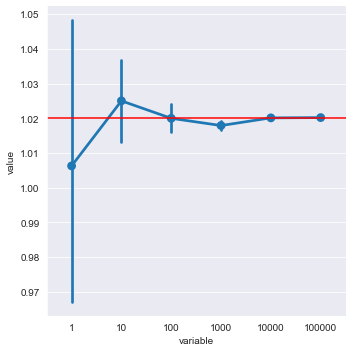

In [10]:
df = pd.DataFrame( results, columns=Nsim)
sns.set_style(style="darkgrid")
g = sns.catplot(x="variable",y ="value", kind = 'point',data=df.melt())

true_mean = S0 * np.exp(r*T)
plt.axhline(y=true_mean,color ='red')

## 定价一个欧式看跌期权

In [11]:
(S0,K,r,q,T,sigma,omega) = (1,1.1,0.02,0,1,0.2,-1)
(Nsim, Nt) = (100000,2)

In [12]:
#首先采样到期日节点的标的资产价格 S（T）
Smat = underlying(S0,r,q,T,sigma,Nsim,Nt)
S = Smat[:,-1]

In [13]:
S

array([0.87121577, 1.01735776, 0.86823883, ..., 1.13105142, 1.08609234,
       1.07324028])

In [14]:
#在到期日将S(T)代入到期权的PAYOFF支付函数中 max(K-S(T),0) 计算均值得到到期期权价格
V_MC = np.exp(-r*T) * np.mean(np.maximum(omega*(S-K),0))
V_MC

0.1278154406222673

In [15]:
# 与解析解BS进行比较，两个值相近
def BlackScholes(S0=100,K=100,r=0.01,q=0.01,T=1,sigma = 0.2,omega=1):
    discount = np.exp(-r*T)
    forward = S0 * np.exp((r-q)*T)
    moneyness = np.log(forward/K)
    vol_sqrt_T = sigma * np.sqrt(T)

    d1 = moneyness / vol_sqrt_T + 0.5 * vol_sqrt_T
    d2 = d1 - vol_sqrt_T

    V = omega * discount * (forward*norm.cdf(omega*d1) - K*norm.cdf(omega*d2))
    return V

In [16]:
V_BS = BlackScholes(S0,K,r,q,T,sigma,omega)
V_BS

0.12765721020973578

## 使用对立变量来缩减误差

In [17]:
def underlying_AV (S0,r,q,T,sigma,Nsim,Nt,antithetic=False):

    t=np.linspace(0,T,Nt)
    dt = np.diff(t)

    if antithetic:
        z1 = np.random.randn(int(Nsim/2),Nt-1) #先生成一半的数
        z = np.vstack([z1,-z1]) #直接求相反数生成剩下的一半

    else:
        z= np.random.randn(Nsim,Nt -1 )
    
    A = (r-q-0.5*(sigma)**2)*dt + sigma * (z*np.sqrt(dt))

    lnS0 = np.tile(np.log(S0),(Nsim,1))
    lnS = lnS0 + np.cumsum(A,axis=1)
    lnS = np.hstack((lnS0,lnS))
    S = np.exp(lnS)
    return S

In [18]:
V_MC = np.exp(-r*T) * np.mean(np.maximum(omega*(S-K),0))
V_MC

0.1278154406222673

In [19]:
Smat_av = underlying_AV(S0,r,q,T,sigma,Nsim,Nt,antithetic=True)
S_av = Smat_av[:,-1]
V_AV = np.exp(-r*T) * np.mean(np.maximum(omega*(S_av-K),0))
V_AV

0.12767233644294232

## 美式期权定价
- 路径模拟


\begin{equation}
S(t_{n+1}) = S(t_n) \cdot \exp ((r-q-\frac{1}{2} \sigma ^2 ) \cdot \delta t + \sigma \sqrt {\delta t} \cdot z) 
\end{equation}

\begin{equation}
ln S(t_{n+1}) = ln S(t_n) + (r-q-\frac{1}{2} \sigma ^2 ) \cdot \delta t + \sigma \sqrt {\delta t} \cdot z
\end{equation}

- 先模拟 $lnS(T)$ 再用 $exp (lnS(T))$ 返回 $S(T)$ 

In [20]:
(S0,r,q,T,sigma) = (1,0.02,0,1,0.2)
(Nsim, Nt) = (30,100)
S = underlying(S0,r,q,T,sigma,Nsim,Nt)
t = np.linspace(0,T,Nt)
label = [ x + ' ' + str(y) for x,y in zip (['path'] * Nsim, np.arange(1,Nsim+1))]
df = pd.DataFrame(S.T, index=t,columns=label)
df

,path 1,path 2,path 3,path 4,path 5,path 6,path 7,path 8,path 9,path 10,...,path 21,path 22,path 23,path 24,path 25,path 26,path 27,path 28,path 29,path 30
0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
0.010101,0.975887,0.990099,0.970019,1.010077,1.013803,0.999982,0.987959,1.018872,0.990592,0.976421,...,0.981254,0.976443,1.026191,0.986895,1.001074,0.977290,0.999535,0.982884,0.989432,1.056684
0.020202,0.972173,1.006264,0.966652,0.969670,1.026042,0.993155,0.957744,1.013411,0.964962,0.984391,...,0.964654,0.941307,0.996354,0.977054,1.036384,0.988105,0.990154,0.989291,0.998451,1.073217
0.030303,0.945548,1.004096,0.972111,0.988002,1.025910,0.981693,0.949291,0.998273,0.940369,0.947071,...,0.936794,0.916245,0.966344,0.999793,1.045443,0.999125,0.993821,0.943873,0.972795,1.143703
0.040404,0.941405,1.002111,0.991468,1.000567,0.998195,0.971020,0.953197,1.033016,0.924124,0.922567,...,0.950643,0.931129,0.974085,1.004928,1.069457,1.004415,1.028898,0.967997,0.961712,1.128618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0.959596,0.774507,1.148739,1.040960,0.905130,0.940507,0.885328,1.045947,0.875434,1.086161,0.909203,...,1.157109,0.651946,0.856671,0.956033,0.981709,1.201037,0.709045,0.801823,1.217883,1.198973
0.969697,0.802628,1.167558,1.047988,0.903173,0.895641,0.889600,0.997561,0.906255,1.083402,0.921805,...,1.149080,0.648064,0.842234,0.927816,0.984334,1.202511,0.713041,0.781075,1.200074,1.216264
0.979798,0.791772,1.178536,1.048554,0.900453,0.930745,0.873870,0.976813,0.934193,1.107032,0.935603,...,1.205240,0.642515,0.818934,0.952127,0.952299,1.184182,0.693819,0.800102,1.201634,1.212937
0.989899,0.790790,1.227807,1.016412,0.898169,0.937982,0.871123,1.018369,0.952492,1.113640,0.907706,...,1.218359,0.631242,0.840553,0.943852,0.932981,1.228289,0.688941,0.772359,1.232437,1.196615


In [21]:
df.iplot( xTitle = 't', yTitle = 'S', mode = 'lines+markers',size=5,title='价格路径模拟')

- LSMC美式期权定价

In [22]:
S = np.array([ [1.00, 1.00, 1.00,1.0,1.0,1.00,1.00,1.00,1.00,1.00],
                [1.05065, 1.16053,1.37341,1.040520,0.988251,0.976515,1.2562,0.978993,0.992926,1.0279],
                [1.2637,0.998913,1.076339,1.065950,0.993791,0.975938,1.09887,0.999051,1.2701,1.2288],
                [1.16451,0.989231,1.33054,1.079766,0.980977,0.996368,1.044480,1.2662,0.969168,1.11321] ])
S

array([[1.      , 1.      , 1.      , 1.      , 1.      , 1.      ,
        1.      , 1.      , 1.      , 1.      ],
       [1.05065 , 1.16053 , 1.37341 , 1.04052 , 0.988251, 0.976515,
        1.2562  , 0.978993, 0.992926, 1.0279  ],
       [1.2637  , 0.998913, 1.076339, 1.06595 , 0.993791, 0.975938,
        1.09887 , 0.999051, 1.2701  , 1.2288  ],
       [1.16451 , 0.989231, 1.33054 , 1.079766, 0.980977, 0.996368,
        1.04448 , 1.2662  , 0.969168, 1.11321 ]])

In [23]:
(S0,r,K,T,omega) = (1,0.06,1.1,3,-1)
(Nt,Nsim) = (4,S.shape[1])

In [24]:
DF = np.exp(-r*T/(Nt-1))
DF

0.9417645335842487

In [25]:
CF = np.maximum(omega * (S[-1,:]-K),0)
path = np.arange(Nsim)

for i in np.arange(Nt-2,0,-1):
    #discount cashflow from T_{i+1} to T{i}
    CF =  CF * DF

    #find the index of the path where option is in the money
    ITM_bool = omega*(S[i]-K) > 0

    #Slice the uderlying and discounted CF under ITM path
    X = S[i,ITM_bool]
    Y = CF[ITM_bool]

    #Regress Y against X with polynomial function
    coef = polyfit(X,Y,2)

    print(f'索引 {i} 回归函数：E[Y|X] = {coef[0]:.3f}x^2 + ({coef[1]:.3f}X) + {coef[2]:.3f}\n')

    #compute the holding value and exercise value
    HV = polyval(coef,X)
    EV = np.maximum(omega*(X-K),0)

    #find the exercise path and update the cashflow
    EP_bool = (EV > HV)
    EP = path[ITM_bool][EP_bool]

    CF[EP] = EV[EP_bool]

V = np.maximum(omega*(S0 - K), np.mean(CF*DF))
V

索引 2 回归函数：E[Y|X] = 16.180x^2 + (-34.141X) + 18.022

索引 1 回归函数：E[Y|X] = 2.923x^2 + (-7.511X) + 4.664



0.10000000000000009

In [26]:
def LSMC(S,K,r,T,N,Nsim,omega,verbose = False):
    DF = np.exp(-r*T/(N-1))
    CF = np.maximum(omega * (S[-1,:]-K),0)
    path = np.arange(Nsim)

    for i in np.arange(N-2,0,-1):
        #discount cashflow from T_{i+1} to T{i}
        CF =  CF * DF

        #find the index of the path where option is in the money
        ITM_bool = omega*(S[i]-K) > 0

        #Slice the uderlying and discounted CF under ITM path
        X = S[i,ITM_bool]
        Y = CF[ITM_bool]

        #Regress Y against X with polynomial function
        coef = polyfit(X,Y,2)

        if verbose:
            print(f'索引 {i} 回归函数：E[Y|X] = {coef[0]:.3f}x^2 + ({coef[1]:.3f}X) + {coef[2]:.3f}\n')

        #compute the holding value and exercise value
        HV = polyval(coef,X)
        EV = np.maximum(omega*(X-K),0)

        #find the exercise path and update the cashflow
        EP_bool = (EV > HV)
        EP = path[ITM_bool][EP_bool]

        CF[EP] = EV[EP_bool]

    V = np.maximum(omega*(S0 - K), np.mean(CF*DF))
    return V

In [27]:
LSMC(S,K,r,T,Nt,Nsim,omega,verbose=True)

索引 2 回归函数：E[Y|X] = 16.180x^2 + (-34.141X) + 18.022

索引 1 回归函数：E[Y|X] = 2.923x^2 + (-7.511X) + 4.664



0.10000000000000009

## 例子：使用50000个对立变量，因此共100000条路径，每一年分成50个间隔因此51个时点

In [28]:
(S0,K,r,q,sigma,T,omega) = (36,40,0.06,0,0.2,1,-1)
(Nsim,Nt) = (100000,51)
Smat = underlying_AV(S0,r,q,T,sigma,Nsim,Nt,antithetic=True)

In [29]:
LSMC(Smat.T,K,r,T,Nt,Nsim,omega,verbose = True)

索引 49 回归函数：E[Y|X] = 0.002x^2 + (-1.097X) + 41.360

索引 48 回归函数：E[Y|X] = 0.003x^2 + (-1.152X) + 42.187

索引 47 回归函数：E[Y|X] = 0.004x^2 + (-1.209X) + 43.008

索引 46 回归函数：E[Y|X] = 0.005x^2 + (-1.276X) + 44.014

索引 45 回归函数：E[Y|X] = 0.006x^2 + (-1.335X) + 44.865

索引 44 回归函数：E[Y|X] = 0.006x^2 + (-1.362X) + 45.250

索引 43 回归函数：E[Y|X] = 0.007x^2 + (-1.414X) + 46.006

索引 42 回归函数：E[Y|X] = 0.008x^2 + (-1.449X) + 46.545

索引 41 回归函数：E[Y|X] = 0.008x^2 + (-1.501X) + 47.311

索引 40 回归函数：E[Y|X] = 0.009x^2 + (-1.540X) + 47.889

索引 39 回归函数：E[Y|X] = 0.010x^2 + (-1.580X) + 48.504

索引 38 回归函数：E[Y|X] = 0.011x^2 + (-1.642X) + 49.441

索引 37 回归函数：E[Y|X] = 0.011x^2 + (-1.633X) + 49.284

索引 36 回归函数：E[Y|X] = 0.012x^2 + (-1.695X) + 50.251

索引 35 回归函数：E[Y|X] = 0.012x^2 + (-1.716X) + 50.517

索引 34 回归函数：E[Y|X] = 0.013x^2 + (-1.775X) + 51.426

索引 33 回归函数：E[Y|X] = 0.013x^2 + (-1.812X) + 52.022

索引 32 回归函数：E[Y|X] = 0.014x^2 + (-1.850X) + 52.598

索引 31 回归函数：E[Y|X] = 0.014x^2 + (-1.851X) + 52.577

索引 30 回归函数：E[Y|X] = 0.015x^2 + 

4.466699662675269

- 和论文中的4.472非常接近

## 百慕大期权

- 每半年执行权利, 执行日期限 [0.5]
- 每三个月执行权利，期限 [0.25,0.5,0.75]
- 每个月执行权利, 期限 [1/12,2/12,3/12...11/12]

In [30]:
(S0,K,r,q,sigma,T,omega) = (50,60,0.03,0.01,0.4,1,-1)
(Nsim,Nt) = (100000,49)
Smat = underlying_AV(S0,r,q,T,sigma,Nsim,Nt,antithetic=True)


In [31]:
V_euro = np.exp(-r*T) * np.mean( np.maximum(omega *(Smat[:,-1]-K),0))
V_euro

13.5820064834101

In [32]:
V_amer = LSMC(Smat.T,K,r,T,Nt,Nsim,omega)
V_amer

13.812370101906513

In [33]:
# Bermudan option

#时间节点
T_vec = np.linspace(0,T,Nt)
T_vec

array([0.        , 0.02083333, 0.04166667, 0.0625    , 0.08333333,
       0.10416667, 0.125     , 0.14583333, 0.16666667, 0.1875    ,
       0.20833333, 0.22916667, 0.25      , 0.27083333, 0.29166667,
       0.3125    , 0.33333333, 0.35416667, 0.375     , 0.39583333,
       0.41666667, 0.4375    , 0.45833333, 0.47916667, 0.5       ,
       0.52083333, 0.54166667, 0.5625    , 0.58333333, 0.60416667,
       0.625     , 0.64583333, 0.66666667, 0.6875    , 0.70833333,
       0.72916667, 0.75      , 0.77083333, 0.79166667, 0.8125    ,
       0.83333333, 0.85416667, 0.875     , 0.89583333, 0.91666667,
       0.9375    , 0.95833333, 0.97916667, 1.        ])

In [34]:
T_ex1 = np.array([0,0.5,T])
idx1 = np.searchsorted(T_vec,T_ex1)
idx1

array([ 0, 24, 48], dtype=int64)

In [35]:
S =Smat[:,idx1].T
S  

array([[ 50.        ,  50.        ,  50.        , ...,  50.        ,
         50.        ,  50.        ],
       [ 63.74768877,  48.75780473,  47.82247788, ...,  50.78651821,
         48.90210666,  75.06099207],
       [ 54.00136093,  45.4751438 ,  65.59575358, ...,  42.15065994,
         43.35595363, 103.69304355]])

In [36]:
V_berm1 = LSMC(S,K,r,T,S.shape[0],Nsim,omega)
V_berm1

13.69429772541042

In [37]:
T_ex2 = np.array([0,0.25,0.5,0.75,T])
idx2 = np.searchsorted(T_vec,T_ex2)
idx2

array([ 0, 12, 24, 36, 48], dtype=int64)

In [38]:
S = Smat[:,idx2].T
V_berm2 = LSMC(S,K,r,T,S.shape[0],Nsim,omega)
V_berm2

13.765438043482613

In [39]:
T_ex3 = np.arange(13)/12
idx3 = np.searchsorted(T_vec,T_ex3)
idx3

array([ 0,  4,  8, 12, 16, 21, 24, 29, 32, 36, 41, 44, 48], dtype=int64)

In [40]:
S = Smat[:,idx3].T 
V_berm3 = LSMC(S,K,r,T,S.shape[0],Nsim,omega)
V_berm3

13.802281729989629

In [41]:
d = {'欧式':V_euro,'百慕大(按半年执行)':V_berm1,'百慕大(按季度执行)':V_berm2,'百慕大(按月执行)':V_berm3,'美式':V_amer}
s = pd.Series(d)
s

欧式            13.582006
百慕大(按半年执行)    13.694298
百慕大(按季度执行)    13.765438
百慕大(按月执行)     13.802282
美式            13.812370
dtype: float64

In [42]:
s.iplot(xTitle = '种类',yTitle = '期权价值', mode = 'lines+markers',size = 10,title='LSMC option pricing',theme='solar')

In [43]:
def LSMC_laguerre(S,K,r,T,N,Nsim,omega,verbose = False, fit_type = 'plain'):
    DF = np.exp(-r*T/(N-1))
    CF = np.maximum(omega * (S[-1,:]-K),0)
    path = np.arange(Nsim)

    for i in np.arange(N-2,0,-1):
        #discount cashflow from T_{i+1} to T{i}
        CF =  CF * DF

        #find the index of the path where option is in the money
        ITM_bool = omega*(S[i]-K) > 0

        #Slice the uderlying and discounted CF under ITM path
        X = S[i,ITM_bool]
        Y = CF[ITM_bool]

        if fit_type == 'laguerre':
            coef = lagfit(X,Y,3)
            HV = lagval(X,coef)
        else:
            #Regress Y against X with polynomial function
            coef = polyfit(X,Y,2)
            #compute the holding value and exercise value
            HV = polyval(coef,X)

        if verbose:
            print(f'索引 {i} 回归函数：E[Y|X] = {coef[0]:.3f}x^2 + ({coef[1]:.3f}X) + {coef[2]:.3f}\n')

        #compute exercise value
        EV = np.maximum(omega*(X-K),0)

        #find the exercise path and update the cashflow
        EP_bool = (EV > HV)
        EP = path[ITM_bool][EP_bool]

        CF[EP] = EV[EP_bool]

    V = np.maximum(omega*(S0 - K), np.mean(CF*DF))
    return V

In [44]:
V_amer_LG = LSMC_laguerre(Smat.T,K,r,T,Nt,Nsim,omega,fit_type = 'laguerre')
V_amer_LG

13.816434898078544

In [45]:
S_LG = Smat[:,idx1].T 
V_berm1_LG = LSMC_laguerre(S_LG,K,r,T,S_LG.shape[0],Nsim,omega,fit_type='laguerre')
V_berm1_LG

13.699403024829577

In [46]:
S_LG = Smat[:,idx2].T 
V_berm2_LG = LSMC_laguerre(S_LG,K,r,T,S_LG.shape[0],Nsim,omega,fit_type='laguerre')
V_berm2_LG

13.76679267431952

In [47]:
S_LG = Smat[:,idx3].T 
V_berm3_LG = LSMC_laguerre(S_LG,K,r,T,S_LG.shape[0],Nsim,omega,fit_type='laguerre')
V_berm3_LG

13.819482140782316

In [48]:
d = {'欧式':V_euro,'百慕大(按半年执行)':V_berm1_LG,'百慕大(按季度执行)':V_berm2_LG,'百慕大(按月执行)':V_berm3_LG,'美式':V_amer_LG}
s = pd.Series(d)
s

欧式            13.582006
百慕大(按半年执行)    13.699403
百慕大(按季度执行)    13.766793
百慕大(按月执行)     13.819482
美式            13.816435
dtype: float64

In [49]:
s.iplot(xTitle = '种类',yTitle = '期权价值', mode = 'lines+markers',size = 10,title='LSMC_Laguerre option pricing',theme='solar')